# Random Forest
Conny Lin | June 2020

## Set up

### local computer

In [ ]:
# import local libraries using host specific paths
import socket, sys
hostname = socket.gethostname().split('.')[0]
# set local path settings based on computer host
if hostname == 'PFC':
    pylibrary = '/Users/connylin/Dropbox/Code/proj'
elif hostname == 'Angular-Gyrus':
    pylibrary = '/Users/connylin/Code/proj'
else:
    assert False, 'host computer not regonized'
# load local libraries
if pylibrary not in sys.path:
    sys.path.insert(1, pylibrary)
# import other standard paths and local variables
from brainstation_capstone.system import host_paths
localpaths = host_paths.get(hostname)
from brainstation_capstone.ml.toolbox import mlSOP
from brainstation_capstone.ml.toolbox.mlSOP import test_model
from brainstation_capstone.ml.toolbox.mlSOP import ml_timer
from brainstation_capstone.vs.plots import hyperparameterplot
# import standard libraries
import time, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt# import local libraries using host specific paths
# report latest run
print(f'last ran on: {datetime.datetime.now()} PT')


getting host computer specific paths


In [ ]:
# import data
from brainstation_capstone.etl.loaddata import nutcracker
data = nutcracker(localpaths, 'nutcracker', ['X_train','X_test','y_train','y_test'])

### google colab

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# import functions and data
print('import functions')
import pandas as pd
import numpy as np
import os, time, datetime
import matplotlib.pyplot as plt

# define file directory
file_dir = '/content/gdrive/My Drive/ED Brain Station/data'

class test_model:
    def __init__(self):
        # set test and train score
        self.test_acc = []
        self.train_acc = []
    def score_data(self, model, datadict):
        self.model = model
        self.data = datadict
        # fit model
        self.model.fit(self.data['X_train'], self.data['y_train'])
        # train score
        train_score = self.model.score(self.data['X_train'], self.data['y_train'])
        print(f"\tTrain Score: {train_score}")
        self.train_acc.append(train_score)
        # test score
        test_score = self.model.score(self.data['X_test'], self.data['y_test'])
        print(f"\tTest Score: {test_score}")
        self.test_acc.append(test_score)

class ml_timer:
    def __init__(self):
        # initate session start time
        self.start = time.time()
        # initiate holder for times
        self.session_times = []
        print('timer starts')

    def param_start(self):
        # update current session start time
        self.current_session_start = time.time()

    def param_end(self):
        end_time = time.time()
        elapsed_time = end_time - self.current_session_start
        print(f'\telapsed time {elapsed_time/60:.3f} min')
        self.session_times.append(elapsed_time)
    
    def session_end(self):
        self.end = time.time()
    
    def get_time(self):
        print(f'total time: {(self.end - self.start)/60:.3f} min')
        return self.session_times

def hyperparameterplot(hyperparameter_list, train_score_list, test_score_list, \
                        hyperparameter_name='', xscale='linear', titlename=''):
    # check if hyperparameter list is string or number
    if isinstance(hyperparameter_list[0], str):
        hyperparameter_label = hyperparameter_list.copy()
        hyperparameter_list = range(len(hyperparameter_list))
    # graph
    plt.figure()
    plt.plot(hyperparameter_list, train_score_list, color='blue', label='train')
    plt.plot(hyperparameter_list, test_score_list, color='red', label='test')
    plt.title(titlename)
    plt.xlabel(hyperparameter_name)
    if isinstance(hyperparameter_list[0], str):
        plt.xticks(labels=hyperparameter_label)
    plt.ylabel('accuracy score')
    plt.xscale(xscale)
    plt.legend()
    plt.show()

def load_nutcracker_csv(dir_datafolder):
    datatype = ['X_train','X_test','y_train','y_test']
    print(f'loading {len(datatype)} files')
    datadict = dict()
    for i, dname in enumerate(datatype):
        print(f'loading file: {i}', end='\r')
        filename = 'nutcracker' + '_' + dname + '.csv'
        filepath = os.path.join(dir_datafolder, filename)
        data = pd.read_csv(filepath, header=None, index_col=False)
        datadict[dname] = data.to_numpy()
    print('\nloading completed')
    return datadict



class ModelEvaluation:
    def __init__(self, model, data_dir):
        self.model = model
        self.data_dir = data_dir
    
    def load_data(self):
        if not hasattr(self, 'data'):
            self.data = load_nutcracker_csv(self.data_dir)

    def cross_val_score(self, cv=5):
        timer = ml_timer()
        if not hasattr(self, 'data'):
            self.load_data()
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(self.model, 
                    self.data['X_train'], 
                    self.data['y_train'], 
                    cv=cv)
        timer.session_end()
        self.runtime_crossval = timer.get_time()
        print(f'cross validation scores: {scores}')
        print(f'validation score (mean):{np.mean(scores)}')
        print(f'validation score (std):{np.std(scores)}')
        self.cross_val_score_ = scores
        return self.cross_val_score_
    
    def fitmodel(self):
        if not hasattr(self, 'data'):
            self.load_data()
        self.model.fit(self.data['X_train'], self.data['y_train'])
        return self.model
    
    def predict(self):
        if not hasattr(self, 'data'):
            self.load_data()
        timer = ml_timer()
        self.y_pred_test = self.model.predict(self.data['X_test'])
        timer.session_end()
        self.runtime_predict = timer.get_time()
        self.y_pred_train = self.model.predict(self.data['X_train'])

    def accuracy_score(self):
        if not hasattr(self, 'data'):
            self.load_data()
        self.score_train = self.model.score(self.data["X_train"], self.data['y_train'])
        print(f'accuracy score on train: {self.score_train}')
        self.score_test = self.model.score(self.data['X_test'], self.data['y_test'])
        print(f'accuracy score on test: {self.score_test}')
        return self.score_train, self.score_test

    def confusion_matrix(self):
        if not hasattr(self, 'y_pred_test'):
            self.predict()
        # fitmodel and predict must proceed this.
        # define dataframe labels
        columns = ['Predicted normal', 'Predicted alcohol']
        indexname = ['True normal', 'True alcohol']
        from sklearn.metrics import confusion_matrix
        # run confusion matrix - test
        self.conf_matrix_test = confusion_matrix(self.data['y_test'], self.y_pred_test, 
                                            normalize='true')
        conf_matrix_test_df = pd.DataFrame(self.conf_matrix_test, columns=columns)
        conf_matrix_test_df.index = indexname
        print('\nconfusion matrix: test data')
        print(conf_matrix_test_df)
        # run confusion matrix - train
        self.conf_matrix_train = confusion_matrix(self.data['y_train'], 
                                            self.y_pred_train, 
                                            normalize='true')
        conf_matrix_train_df = pd.DataFrame(self.conf_matrix_train, columns=columns)
        conf_matrix_train_df.index = indexname
        print('\nconfusion matrix: train data')
        print(conf_matrix_train_df)
        return self.conf_matrix_test, self.conf_matrix_train
    
    def display_confusion_matrix(self):
        if not hasattr(self, 'conf_matrix_test'):
            self.confusion_matrix()
        # confusion_matrix must proceed this
        display_labels = ['normal', 'alcohol']
        from sklearn.metrics import ConfusionMatrixDisplay
        print('\nconfusion matrix for test')
        plt.figure()
        ConfusionMatrixDisplay(self.conf_matrix_test, display_labels=display_labels).plot()
        plt.show()
        print('\nconfusion matrix for train')
        plt.figure()
        ConfusionMatrixDisplay(self.conf_matrix_train, display_labels=display_labels).plot()
        plt.show()

    def classification_report(self):
        if not hasattr(self, 'y_pred_test'):
            self.predict()
        from sklearn.metrics import classification_report
        self.eval_score_report = classification_report(self.data['y_test'], 
                                                        self.y_pred_test)
        print(self.eval_score_report)
    
    def print_evaluation_scores(self):
        if not hasattr(self, 'y_pred_test'):
            self.predict()        
        from sklearn.metrics import precision_score
        from sklearn.metrics import recall_score
        from sklearn.metrics import f1_score
        self.precision_score = precision_score(self.data["y_test"], self.y_pred_test)
        self.recall_score = recall_score(self.data["y_test"], self.y_pred_test)
        self.f1_score = f1_score(self.data["y_test"], self.y_pred_test)
        print(f'precision_score = {self.precision_score}')
        print(f'recall_score = {self.recall_score}')
        print(f'f1_score = {self.f1_score}')
    
    def test_data_class_proba(self):
        if not hasattr(self, 'data'):
            self.load_data()        
        false_proba = np.count_nonzero(self.data['y_test']) / self.data['y_test'].shape[0]
        true_proba = 1.0 - false_proba
        print(f'test set normal case probability: {false_proba}')
        print(f'test set alcohol case probability: {true_proba}')
        self.real_proba = dict()
        self.real_proba['false_proba'] = false_proba
        self.real_proba['true_proba'] = true_proba
    
    def predict_proba(self):
        if not hasattr(self, 'data'):
            self.load_data()
        self.y_proba_test = self.model.predict_proba(self.data['X_test'])[:,1]
        self.y_proba_train = self.model.predict_proba(self.data['X_train'])[:,1]
        return self.y_proba_test, self.y_proba_train

    def proba_thresholds(self):
        if not hasattr(self, 'data'):
            self.load_data()
        from sklearn.metrics import accuracy_score
        from sklearn.metrics import precision_score
        from sklearn.metrics import recall_score
        # Vary thresholds by 0.05 from 0.05 to 0.95
        thresholds = np.arange(0.05, 1, 0.05)
        precisions = list()
        recalls = list()
        neg_recalls = list()
        for threshold in thresholds:
            # Apply threshold
            y_threshold = np.where(self.y_proba_test > threshold, 1, 0)
            # Calculate precision and recall
            precision = precision_score(self.data['y_test'], y_threshold)
            recall = recall_score(self.data['y_test'], y_threshold)
            neg_recall = recall_score(1-self.data['y_test'], 1-y_threshold)
            # Append to list
            precisions.append(precision)
            recalls.append(recall)
            neg_recalls.append(neg_recall)
        # Visualize the result
        plt.figure()
        plt.plot(thresholds, precisions, label='precision', marker='o')
        plt.plot(thresholds, recalls, label='recall', marker='o')
        plt.xlim(0, 1)
        plt.xlabel('threshold')
        plt.ylabel('score')
        plt.legend()
        plt.show()
        return precisions, recalls, neg_recalls
        
    def roc_auc(self):
        if hasattr(self, 'y_proba_train'):
            self.predict_proba()
        from sklearn.metrics import roc_curve, roc_auc_score
        # get roc auc train
        fprs_train, tprs_train, thresholds_train = roc_curve(self.data['y_train'], self.y_proba_train)
        roc_auc_train = roc_auc_score(self.data['y_train'], self.y_proba_train)
        # get roc auc test
        fprs_test, tprs_test, thresholds_test = roc_curve(self.data['y_test'], self.y_proba_test)
        roc_auc_test = roc_auc_score(self.data['y_test'], self.y_proba_test)
        # Plot the ROC curve.
        plt.figure()
        plt.plot(fprs_train, tprs_train, color='gray', lw=5, label='train', linestyle=' ', marker='.')
        plt.plot(fprs_test, tprs_test, lw=1, color='red', label='test')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='expected')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC and AUC')
        plt.legend(loc="best")
        plt.show()
        print(f"Test AUC score: {roc_auc_test}")
        print(f"Train AUC score: {roc_auc_train}")
        self.roc_auc_test = roc_auc_test
        self.roc_auc_train = roc_auc_train
    
    def save(self, savedir):
        # remove data from object to save space
        if hasattr(self, 'data'):
            delattr(self, 'data')
        if hasattr(self, 'y_pred_test'):
            delattr(self, 'y_pred_test')
        if hasattr(self, 'y_pred_train'):
            delattr(self, 'y_pred_train')
        if hasattr(self, 'y_proba_test'):
            delattr(self, 'y_proba_test') 
        if hasattr(self, 'y_proba_train'):
            delattr(self, 'y_proba_train') 
        # get model name
        model_type = type(self.model)
        model_type_str  = str(model_type)
        model_name_components = model_type_str.split('.')
        model_name = model_name_components[-1].replace("'>","")
        # save
        import pickle, os
        savepath = os.path.join(savedir, model_name+'_eval.pickle')
        pickle.dump(self, open(savepath, 'wb'))

    def excel_input_array(self):
        # TODO: write input validation code
        report = [np.mean(self.cross_val_score_),
                    np.std(self.cross_val_score_),
                    self.score_train,
                    self.score_test,
                    self.precision_score,
                    self.recall_score,
                    self.f1_score,
                    self.roc_auc_train,
                    self.roc_auc_test,
                    self.runtime_crossval,
                    self.runtime_predict]
        print(report)
        print(self.model)
    
    def standard(self, save_dir):
        print('\nloading data from directory')
        self.load_data()
        print('\nruning cross validation scores (this takes a while):')
        self.cross_val_score(5)
        print('\nfit model...')
        self.fitmodel()
        print('predict model...')
        self.predict()
        print('\naccuracy scores:')
        self.accuracy_score()
        print('\nconfusion matrix:')
        self.confusion_matrix()
        self.display_confusion_matrix()
        print('\nclassification report:')
        self.classification_report()
        self.print_evaluation_scores()
        print('\nreal data class proba:')
        self.test_data_class_proba()
        print('\n prediction proba:')
        self.predict_proba()
        print('\nproba threshold analysis:')
        self.proba_thresholds()
        print('\nROC AUC analysis:')
        self.roc_auc()
        print('\nSaving model...')
        self.save(save_dir)
        print('\nexcel record:')
        self.excel_input_array()




import functions


In [ ]:
# get files from google drive
print('loading data to data dictionary')
datatype = ['X_train','X_test','y_train','y_test']
dataname = 'nutcracker'
data = dict()
for i, dname in enumerate(datatype):
    print(f'loading file: {i}', end='\r')
    filename = dataname + '_' + dname + '.csv'
    filepath = os.path.join(file_dir, filename)
    data[dname] = np.loadtxt(filepath, delimiter=',')
print('loading completed')
# print the array shape to confirm successful loading
print(data['X_train'].shape)
# report time run
print(f'last ran on: {datetime.datetime.now()} PT')

## untuned model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# run a simple one
my_model = RandomForestClassifier(n_estimators=10, random_state=318)
my_model.fit(X_train, y_train)

print(f'train score: {my_model.score(X_train, y_train)}')
print(f'test score: {my_model.score(X_test, y_test)}')

train score: 0.9918475
test score: 0.881155


Random forest is a lot better! Just a bit over fitting with 10 estimators.

Run a range of it

## estimators 1-52
over 10-20 seems to be reaching plataeu

In [ ]:
# run 52 estimators
estimator_number = list(range(1, 52))
train_scores = []
test_scores = []


for number in estimator_number:
    my_model = RandomForestClassifier(n_estimators=number, random_state=318)
    my_model.fit(X_train, y_train)

    train_scores.append(my_model.score(X_train, y_train))
    test_scores.append(my_model.score(X_test, y_test))
    
    print(f'finished {number} estimators', end='\r')

Ran 52 estimators and then stuck for a day without any movemnent.

In [ ]:
len(test_scores)

52

In [ ]:
estimator_number = np.arange(52)
len(estimator_number)

52

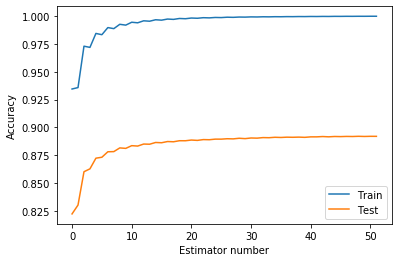

In [ ]:
plt.figure()
plt.plot(estimator_number, train_scores, label="Train")
plt.plot(estimator_number, test_scores, label="Test")
plt.xlabel("Estimator number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

A lot of overfitting and maxed out at around 10 estimators. Need to be tuned.

## n_estimators 3 - 100, max_features

Run rough tuning: 

In [ ]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# get standard machine learning input data
from brainstation_capstone.etl.datatransform import Nutcracker
X_train, X_test, y_train, y_test = Nutcracker(localpaths['datapath']).mldata(feature_reduction='None')

# define models and parameters
model = RandomForestClassifier()
n_estimators = [3, 5, 10, 50, 100]
max_features = ['sqrt', 'log2']
n_splits = 5
cv = 5 # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=318)

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, 
                           cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.892502 using {'max_features': 'sqrt', 'n_estimators': 100}
0.858902 (0.001519) with: {'max_features': 'sqrt', 'n_estimators': 3}
0.871069 (0.000546) with: {'max_features': 'sqrt', 'n_estimators': 5}
0.881167 (0.000331) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.891103 (0.000267) with: {'max_features': 'sqrt', 'n_estimators': 50}
0.892502 (0.000318) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.858861 (0.000718) with: {'max_features': 'log2', 'n_estimators': 3}
0.871131 (0.000436) with: {'max_features': 'log2', 'n_estimators': 5}
0.880914 (0.000214) with: {'max_features': 'log2', 'n_estimators': 10}
0.891031 (0.000340) with: {'max_features': 'log2', 'n_estimators': 50}
0.892395 (0.000311) with: {'max_features': 'log2', 'n_estimators': 100}


May consider changing ccp_alpha to avoid over fitting. for now stick with n_estimator=100, max_features=sqrt

## final eval

In [ ]:
data_dir = file_dir
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=318, max_features='sqrt', n_estimators=100)
model_eval = ModelEvaluation(model, data_dir)
model_eval.standard(data_dir)


loading data from directory
loading 4 files

loading completed

runing cross validation scores (this takes a while):
timer starts


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
